In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Input, ReLU, Add, Layer, Activation, LSTM
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 

In [ ]:
from tensorflow.python.keras.layers.convolutional_recurrent import *

In [ ]:
def get_split(x):
  b, row, cols, ch = x.shape
  num_add = 2 * cols - 1

  padding_right = tf.constant([[0, 0], [0, 0], [0, num_add - cols], [0, 0]])
  padding_left = tf.constant([[0, 0], [0, 0], [num_add - cols, 0], [0, 0]])
  right = tf.pad(x, paddings=padding_right)
  left = tf.pad(x, paddings=padding_left)
  r_list = array_ops.split(right, row, axis=1)
  l_list = array_ops.split(left, row, axis=1)
  for i in range(len(r_list)):
    r_list[i] =  tf.roll(r_list[i], shift=[0, 0, i], axis=[0, 0, 2])
    l_list[i] =  tf.roll(l_list[i], shift=[0, 0, -i], axis=[0, 0, 2])

  right = tf.reshape(tf.stack(r_list, axis=1), (-1, row, num_add, ch)) 
  left = tf.reshape(tf.stack(l_list, axis=1), (-1, row, num_add, ch))

  right = tf.transpose(right, perm=[0, 2, 1, 3])
  left = tf.transpose(left, perm=[0, 2, 1, 3])

  right = tf.reshape(right, (-1, num_add, row, 1, ch))
  left = tf.reshape(left, (-1, num_add, row, 1, ch))
  return right, left

In [ ]:
def add_rl(x, y):
  b, time, row, cols, ch = x.shape

  right = tf.reshape(x, (-1, time, row, ch))
  left = tf.reshape(y, (-1, time, row, ch))

  right = tf.transpose(right, perm=[0, 2, 1, 3])
  left = tf.transpose(left, perm=[0, 2, 1, 3])

  r_list = array_ops.split(right, row, axis=1)
  l_list = array_ops.split(left, row, axis=1)
  for i in range(len(r_list)):
    r_list[i] =  tf.roll(r_list[i], shift=[0, 0, -i], axis=[0, 0, 2])
    l_list[i] =  tf.roll(l_list[i], shift=[0, 0, i], axis=[0, 0, 2])
  
  right = tf.reshape(tf.stack(r_list, axis=1), (-1, row, time, ch))
  y = tf.zeros_like(l_list[0], dtype=l_list[0].dtype)
  l_list = [y] + l_list[:-1]
  left = tf.reshape(tf.stack(l_list, axis=1), (-1, row, time, ch))

  return right, left
  # return right[:, :, :row, :] + left[:, :, :row, :]

In [ ]:
t = np.ones((2, 3, 3, 1), dtype=np.float32)
t[0, :, :, :] = 3.4
t[1, :, :, :] = 2
t = tf.Variable(t)

In [ ]:
t[0, :, :, 0]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[3.4, 3.4, 3.4],
       [3.4, 3.4, 3.4],
       [3.4, 3.4, 3.4]], dtype=float32)>

In [ ]:
r, l = get_split(t)

In [ ]:
l[0, :, :, :, 0]

<tf.Tensor: shape=(5, 3, 1), dtype=float32, numpy=
array([[[0. ],
        [0. ],
        [3.4]],

       [[0. ],
        [3.4],
        [3.4]],

       [[3.4],
        [3.4],
        [3.4]],

       [[3.4],
        [3.4],
        [0. ]],

       [[3.4],
        [0. ],
        [0. ]]], dtype=float32)>

In [ ]:
lnew = ConvLSTM2D(1, (2, 1), padding='same', return_sequences=True, go_backwards=True,)(l)
rnew = ConvLSTM2D(1, (2, 1), padding='same', return_sequences=True, )(r)

In [ ]:
r2, l2 = add_rl(rnew, lnew)

In [ ]:
l = tf.reverse(l, axis=[1, 3])

In [ ]:
tf.transpose(tf.reshape(lnew, (-1, 5, 3, 1)), perm=[0, 2, 1, 3])[0, :, :, 0]

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.        , 0.10645743],
       [0.        , 0.        , 0.        , 0.10456979, 0.07840092],
       [0.10897781, 0.15819164, 0.17983194, 0.16671334, 0.08432087]],
      dtype=float32)>

In [ ]:
r2[0, :, :, 0]

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[ 0.70073986,  0.04309344, -0.02251343, -0.0026203 , -0.14268982],
       [ 0.70073986,  0.04309344, -0.02251343, -0.        ,  0.        ],
       [ 0.70073986,  0.8609684 ,  0.9080044 ,  0.        ,  0.        ]],
      dtype=float32)>

In [ ]:
tf.transpose(tf.reshape(lnew, (-1, 5, 3, 1)), perm=[0, 2, 1, 3])[0, :, :, 0]

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.        , 0.10645743],
       [0.        , 0.        , 0.        , 0.10456979, 0.07840092],
       [0.10897781, 0.15819164, 0.17983194, 0.16671334, 0.08432087]],
      dtype=float32)>

In [ ]:
l2[0, :, :, 0]

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.10645743],
       [0.07840092, 0.        , 0.        , 0.        , 0.10456979]],
      dtype=float32)>

In [ ]:
rr = r2[:, :, :3, :] + l2[:, :, 2:, :]

In [ ]:
rr[0, :, :, 0]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[-0.32123706, -0.532803  , -0.66806126],
       [-0.42844605, -0.6219846 , -0.72393286],
       [-0.42844605, -0.6219846 , -0.72393286]], dtype=float32)>

In [ ]:
class MaskConv2D(Conv2D):
    def __init__(self, *args, mask_type = 'A', **kwargs):
        super().__init__(*args, **kwargs)
        self.mask = None
        self.mask_t = mask_type

    def build(self, input_shape):
        super().build(input_shape)
        filter_height, filter_width, filters_input, filters_output = self.kernel.shape
        self.mask = np.ones(self.kernel.shape).astype('f')
        yc, xc = filter_height // 2, filter_width // 2
        self.mask[yc + 1:,] = 0.0
        self.mask[yc, xc + 1:] = 0.0
        if self.mask_t == 'A':
          self.mask[yc, xc] = 0.0
    def call(self, x):
        outputs = tf.keras.backend.conv2d(x, self.kernel * self.mask, strides=self.strides, padding=self.padding)
        if self.use_bias:
            outputs = tf.keras.backend.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        return outputs

    def get_config(self):
        return dict(list(super().get_config().items()))

In [ ]:
class myConvLSTM2DCell(ConvLSTM2DCell):
    def __init__(self, *args, **kwargs):
      super().__init__(*args, **kwargs)
      self.mask_input = None
    def build(self, input_shape):
        super().build(input_shape)
        # print(self.kernel.shape)
        self.mask = np.ones(self.kernel.shape)
        row, cols, inp, out = self.kernel.shape
        self.mask[:, cols//2 + 1:, :, :] = 0.0

    def call(self, inputs, states, training=None):
      h_tm1 = states[0]  # previous memory state
      c_tm1 = states[1]  # previous carry state

      # dropout matrices for input units
      dp_mask = self.get_dropout_mask_for_cell(inputs, training, count=4)
      # dropout matrices for recurrent units
      rec_dp_mask = self.get_recurrent_dropout_mask_for_cell(
          h_tm1, training, count=4)

      if 0 < self.dropout < 1.:
        inputs_i = inputs * dp_mask[0]
        inputs_f = inputs * dp_mask[1]
        inputs_c = inputs * dp_mask[2]
        inputs_o = inputs * dp_mask[3]
      else:
        inputs_i = inputs
        inputs_f = inputs
        inputs_c = inputs
        inputs_o = inputs

      if 0 < self.recurrent_dropout < 1.:
        h_tm1_i = h_tm1 * rec_dp_mask[0]
        h_tm1_f = h_tm1 * rec_dp_mask[1]
        h_tm1_c = h_tm1 * rec_dp_mask[2]
        h_tm1_o = h_tm1 * rec_dp_mask[3]
      else:
        h_tm1_i = h_tm1
        h_tm1_f = h_tm1
        h_tm1_c = h_tm1
        h_tm1_o = h_tm1

      (kernel_i, kernel_f,
      kernel_c, kernel_o) = array_ops.split(self.kernel * self.mask, 4, axis=3)
      (recurrent_kernel_i,
      recurrent_kernel_f,
      recurrent_kernel_c,
      recurrent_kernel_o) = array_ops.split(self.recurrent_kernel, 4, axis=3)

      if self.use_bias:
        bias_i, bias_f, bias_c, bias_o = array_ops.split(self.bias, 4)
      else:
        bias_i, bias_f, bias_c, bias_o = None, None, None, None

      x_i = self.input_conv(inputs_i, kernel_i, bias_i, padding=self.padding)
      x_f = self.input_conv(inputs_f, kernel_f, bias_f, padding=self.padding)
      x_c = self.input_conv(inputs_c, kernel_c, bias_c, padding=self.padding)
      x_o = self.input_conv(inputs_o, kernel_o, bias_o, padding=self.padding)
      h_i = self.recurrent_conv(h_tm1_i, recurrent_kernel_i)
      h_f = self.recurrent_conv(h_tm1_f, recurrent_kernel_f)
      h_c = self.recurrent_conv(h_tm1_c, recurrent_kernel_c)
      h_o = self.recurrent_conv(h_tm1_o, recurrent_kernel_o)

      i = self.recurrent_activation(x_i + h_i)
      f = self.recurrent_activation(x_f + h_f)
      c = f * c_tm1 + i * self.activation(x_c + h_c)
      o = self.recurrent_activation(x_o + h_o)
      h = o * self.activation(c)
      return h, [h, c]


    def input_conv(self, x, w, b=None, padding='valid'):
        conv_out = K.conv2d(x, w, strides=self.strides,
                            padding=padding,
                            data_format=self.data_format,
                            dilation_rate=self.dilation_rate)
        if b is not None:
            conv_out = K.bias_add(conv_out, b,
                                  data_format=self.data_format)
        return conv_out

    def recurrent_conv(self, x, w):
        conv_out = K.conv2d(x, w, strides=(1, 1),
                            padding='same',
                            data_format=self.data_format)
        return conv_out

    def get_config(self):
        config = {'filters': self.filters,
                  'kernel_size': self.kernel_size,
                  'strides': self.strides,
                  'padding': self.padding,
                  'data_format': self.data_format,
                  'dilation_rate': self.dilation_rate,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation':
                      activations.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'unit_forget_bias': self.unit_forget_bias,
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint':
                      constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout}
        base_config = super(ConvLSTM2DCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
@keras_export('keras.layers.ConvLSTM2D')
class myConvLSTM2D(ConvRNN2D):

  def __init__(self,
               filters,
               kernel_size,
               strides=(1, 1),
               padding='valid',
               data_format=None,
               dilation_rate=(1, 1),
               activation='tanh',
               recurrent_activation='hard_sigmoid',
               use_bias=True,
               kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal',
               bias_initializer='zeros',
               unit_forget_bias=True,
               kernel_regularizer=None,
               recurrent_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               recurrent_constraint=None,
               bias_constraint=None,
               return_sequences=False,
               go_backwards=False,
               stateful=False,
               dropout=0.,
               recurrent_dropout=0.,
               **kwargs):
    cell = myConvLSTM2DCell(filters=filters,
                          kernel_size=kernel_size,
                          strides=strides,
                          padding=padding,
                          data_format=data_format,
                          dilation_rate=dilation_rate,
                          activation=activation,
                          recurrent_activation=recurrent_activation,
                          use_bias=use_bias,
                          kernel_initializer=kernel_initializer,
                          recurrent_initializer=recurrent_initializer,
                          bias_initializer=bias_initializer,
                          unit_forget_bias=unit_forget_bias,
                          kernel_regularizer=kernel_regularizer,
                          recurrent_regularizer=recurrent_regularizer,
                          bias_regularizer=bias_regularizer,
                          kernel_constraint=kernel_constraint,
                          recurrent_constraint=recurrent_constraint,
                          bias_constraint=bias_constraint,
                          dropout=dropout,
                          recurrent_dropout=recurrent_dropout,
                          dtype=kwargs.get('dtype'))
    super(myConvLSTM2D, self).__init__(cell,
                                     return_sequences=return_sequences,
                                     go_backwards=go_backwards,
                                     stateful=stateful,
                                     **kwargs)
    self.activity_regularizer = regularizers.get(activity_regularizer)

  def call(self, inputs, mask=None, training=None, initial_state=None):
    self._maybe_reset_cell_dropout_mask(self.cell)
    return super(myConvLSTM2D, self).call(inputs,
                                        mask=mask,
                                        training=training,
                                        initial_state=initial_state)

  @property
  def filters(self):
    return self.cell.filters

  @property
  def kernel_size(self):
    return self.cell.kernel_size

  @property
  def strides(self):
    return self.cell.strides

  @property
  def padding(self):
    return self.cell.padding

  @property
  def data_format(self):
    return self.cell.data_format

  @property
  def dilation_rate(self):
    return self.cell.dilation_rate

  @property
  def activation(self):
    return self.cell.activation

  @property
  def recurrent_activation(self):
    return self.cell.recurrent_activation

  @property
  def use_bias(self):
    return self.cell.use_bias

  @property
  def kernel_initializer(self):
    return self.cell.kernel_initializer

  @property
  def recurrent_initializer(self):
    return self.cell.recurrent_initializer

  @property
  def bias_initializer(self):
    return self.cell.bias_initializer

  @property
  def unit_forget_bias(self):
    return self.cell.unit_forget_bias

  @property
  def kernel_regularizer(self):
    return self.cell.kernel_regularizer

  @property
  def recurrent_regularizer(self):
    return self.cell.recurrent_regularizer

  @property
  def bias_regularizer(self):
    return self.cell.bias_regularizer

  @property
  def kernel_constraint(self):
    return self.cell.kernel_constraint

  @property
  def recurrent_constraint(self):
    return self.cell.recurrent_constraint

  @property
  def bias_constraint(self):
    return self.cell.bias_constraint

  @property
  def dropout(self):
    return self.cell.dropout

  @property
  def recurrent_dropout(self):
    return self.cell.recurrent_dropout

  def get_config(self):
    config = {'filters': self.filters,
              'kernel_size': self.kernel_size,
              'strides': self.strides,
              'padding': self.padding,
              'data_format': self.data_format,
              'dilation_rate': self.dilation_rate,
              'activation': activations.serialize(self.activation),
              'recurrent_activation': activations.serialize(
                  self.recurrent_activation),
              'use_bias': self.use_bias,
              'kernel_initializer': initializers.serialize(
                  self.kernel_initializer),
              'recurrent_initializer': initializers.serialize(
                  self.recurrent_initializer),
              'bias_initializer': initializers.serialize(self.bias_initializer),
              'unit_forget_bias': self.unit_forget_bias,
              'kernel_regularizer': regularizers.serialize(
                  self.kernel_regularizer),
              'recurrent_regularizer': regularizers.serialize(
                  self.recurrent_regularizer),
              'bias_regularizer': regularizers.serialize(self.bias_regularizer),
              'activity_regularizer': regularizers.serialize(
                  self.activity_regularizer),
              'kernel_constraint': constraints.serialize(
                  self.kernel_constraint),
              'recurrent_constraint': constraints.serialize(
                  self.recurrent_constraint),
              'bias_constraint': constraints.serialize(self.bias_constraint),
              'dropout': self.dropout,
              'recurrent_dropout': self.recurrent_dropout}
    base_config = super(ConvLSTM2D, self).get_config()
    del base_config['cell']
    return dict(list(base_config.items()) + list(config.items()))

  @classmethod
  def from_config(cls, config):
    return cls(**config)

In [ ]:
def ResBlockRnn(input_):
  b, row, cols, ch = input_.shape
  model = tf.reshape(input_, [-1, row, 1, cols, ch])

  model = myConvLSTM2D(8, padding='same', kernel_size=(1,3), return_sequences=True)(model)

  b, row, r, cols, ch = model.shape
  model = tf.reshape(model, [-1, row, cols, ch])

  model = MaskConv2D(16, (1, 1), padding='same', mask_type='B')(model)
  model = Add()([input_, model])
  return model

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
inputs = Input((28, 28, 1))
model = MaskConv2D(16, (3,3), padding='same')(inputs)

for i in range(7):
  model = ResBlockRnn(model)

model = MaskConv2D(16, (1,1), padding='same', mask_type='B')(model)
model = ReLU()(model)

model = MaskConv2D(1, (1,1), padding='same', mask_type='B')(model)
outputs = Activation('sigmoid')(model)

model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam")
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
mask_conv2d (MaskConv2D)        (None, 28, 28, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Reshape (TensorFlow [(None, 28, 1, 28, 1 0           mask_conv2d[0][0]                
__________________________________________________________________________________________________
my_conv_lst_m2d (myConvLSTM2D)  (None, 28, 1, 28, 8) 2336        tf_op_layer_Reshape[0][0]        
______________________________________________________________________________________________

11493376/11490434 [==============================] - 0s 0us/step


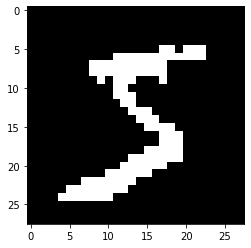

In [ ]:
(X_train, y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
data = np.concatenate((X_train, X_test), axis=0)
data = data.astype('float32')
data /= 255
data = np.around(1 - data)
data = data.reshape(data.shape[0], 28, 28, 1)
plt.imshow(data[0, :, :, 0], cmap='Greys')

In [ ]:
model.fit(data, data,
      batch_size=32, epochs=10)

Epoch 1/10
2188/2188 [==============================] - 2002s 915ms/step - loss: 0.1096
Epoch 2/10
2188/2188 [==============================] - 1977s 904ms/step - loss: 0.0939
Epoch 3/10
2188/2188 [==============================] - 2086s 954ms/step - loss: 0.0909
Epoch 4/10
2188/2188 [==============================] - 2034s 930ms/step - loss: 0.0894
Epoch 5/10
2188/2188 [==============================] - 1960s 896ms/step - loss: 0.0882
Epoch 6/10
2188/2188 [==============================] - 1967s 899ms/step - loss: 0.0873
Epoch 7/10
2188/2188 [==============================] - 1952s 892ms/step - loss: 0.0866
Epoch 8/10
2188/2188 [==============================] - 1955s 893ms/step - loss: 0.0859
Epoch 9/10
2188/2188 [==============================] - 1952s 892ms/step - loss: 0.0854
Epoch 10/10
2188/2188 [==============================] - 1947s 890ms/step - loss: 0.0850


In [ ]:
pixels_new = np.zeros((1, 28, 28, 1))
b, rows, cols, chan = pixels_new.shape
for row in range(rows):
    for col in range(cols):
        predict = model.predict(pixels_new)
        p = predict[0, row, col, 0]
        pixels_new[0][row][col][0] = np.random.choice([0, 1], p=[1 - p, p])

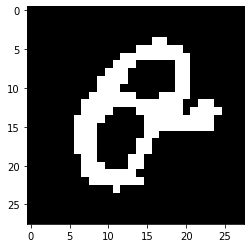

In [ ]:
plt.imshow(pixels_new[0, :, :, 0], cmap='Greys')

In [ ]:
z = np.ones((2, 3, 3, 2))

In [ ]:
z[:,:,:,1] = 3.4

In [ ]:
z[:,:,:,0]

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

In [ ]:
z[:, :, :]

array([[[[1. , 3.4],
         [1. , 3.4],
         [1. , 3.4]],

        [[1. , 3.4],
         [1. , 3.4],
         [1. , 3.4]],

        [[1. , 3.4],
         [1. , 3.4],
         [1. , 3.4]]],


       [[[1. , 3.4],
         [1. , 3.4],
         [1. , 3.4]],

        [[1. , 3.4],
         [1. , 3.4],
         [1. , 3.4]],

        [[1. , 3.4],
         [1. , 3.4],
         [1. , 3.4]]]])

In [ ]:
z_ten = tf.convert_to_tensor(z)
b, row, cols, ch = z_ten.shape

In [ ]:
zzz = tf.reshape(z_ten, [-1] + list([row, 1, cols, ch]))

In [ ]:
zzz[:, 0, 0, :, 1]

<tf.Tensor: shape=(2, 3), dtype=float64, numpy=
array([[3.4, 3.4, 3.4],
       [3.4, 3.4, 3.4]])>

In [ ]:
mask = np.zeros((4,4,3))
for i in range(4):
    mask[i,i,] = 1

In [ ]:
mask[:, :,]

array([[[1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [1., 1., 1.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [1., 1., 1.]]])

In [ ]:
ll = tf.Variable(mask)

In [ ]:
ll.shape

TensorShape([4, 4, 3])

In [ ]:
res = tf.keras.backend.dot(ll,z_ten)

In [ ]:
rr = res.numpy()
rr.shape

(4, 4, 4, 2)

In [ ]:
rr[:, :, :, 0]

array([[[3., 3., 3., 3.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [3., 3., 3., 3.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [3., 3., 3., 3.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [3., 3., 3., 3.]]])

In [ ]:
test_ones = np.ones((2, 3, 3, 2))
test_ones[:,:,:,1] = 3.4
z_new = tf.convert_to_tensor(test_ones)

In [ ]:
test_ones[:,:,:,:]

array([[[[1. , 3.4],
         [1. , 3.4],
         [1. , 3.4]],

        [[1. , 3.4],
         [1. , 3.4],
         [1. , 3.4]],

        [[1. , 3.4],
         [1. , 3.4],
         [1. , 3.4]]],


       [[[1. , 3.4],
         [1. , 3.4],
         [1. , 3.4]],

        [[1. , 3.4],
         [1. , 3.4],
         [1. , 3.4]],

        [[1. , 3.4],
         [1. , 3.4],
         [1. , 3.4]]]])

In [ ]:
tt = tf.reshape(z_new, (2,2,3,3,1)).numpy()

In [ ]:
tt[0, 1,:,:, 0]

array([[3.4, 1. , 3.4],
       [1. , 3.4, 1. ],
       [3.4, 1. , 3.4]])

In [ ]:
mask_new = np.zeros((3, 3, 3))
for i in range(3):
    mask_new[i, i, i] = 1
ll_new = tf.Variable(mask_new)

In [ ]:
nnn = np.zeros((2, 3, 3, 3, 4))

In [ ]:
for i in range(z_new.shape[0]):
  nnn[i,] = tf.keras.backend.dot(ll, z_new[i]).numpy()

In [ ]:
def rev5d(inputs):
  batch, row, col, channel = inputs.shape
  mask = np.zeros((col, channel, channel))
  for i in range(channel):
    mask[:, i, i] = 1.0
  ll_new = tf.Variable(mask, dtype='float32')
  res_new = tf.keras.backend.dot(inputs, ll_new)
  # zer = tf.Variable()
  zer = np.zeros(res_new.shape)
  for i in range(row):
    zer[:, i, i, :, :] = 1.0
  zer = tf.Variable(zer, dtype='float32')
  return res_new

In [ ]:
i = Input((3, 3, 4), batch_size=32)
m = Conv2D(2, (3, 3), padding='same')(i)
rev5d(m)

<tf.Tensor 'Mul_2:0' shape=(32, 3, 3, 3, 2) dtype=float32>

In [ ]:
rev5d(z_new).numpy()[0, 1, :, :, 0]

32 3 3 2


array([[0., 0., 0.],
       [1., 1., 1.],
       [0., 0., 0.]])

In [ ]:
nnn.shape

(2, 3, 3, 3, 4)

In [ ]:
nnn[0, :, :, :, 0]

array([[[1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [1., 1., 1.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [1., 1., 1.]]])

In [ ]:
mask_new[:,]

array([[[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]],

       [[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]],

       [[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]])

In [ ]:
test_ones = np.ones((2, 3, 3, 4))
test_ones[:,:,:,1] = 3.4
z_new = tf.convert_to_tensor(test_ones)

In [ ]:
mask_new = np.zeros((3, 4, 4))
for i in range(4):
    mask_new[:, i, i] = 1
ll_new = tf.Variable(mask_new)

In [ ]:
res_new = tf.keras.backend.dot(z_new, ll_new)
rr_new = res_new.numpy()
rr_new.shape

(2, 3, 3, 3, 4)

In [ ]:
rr_new[0, :, :, :, 0]

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

In [ ]:
zer = np.zeros((2, 3, 3, 3, 4))
for i in range(3):
  zer[:, i, i, :, :] = 1

In [ ]:
zer[0, 0, :, :, 0]

array([[1., 1., 1.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [ ]:
res_22 = zer * rr_new

In [ ]:
res_22[0, 2,:, :, 1]

array([[0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [3.4, 3.4, 3.4]])